# Libraries

In [26]:
                        import pickle
import pandas as pd
import seaborn as sns
from os.path import exists
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

In [27]:
import numpy as np

import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
# from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
# from datetime import datetime

from textblob import TextBlob
from sklearn import preprocessing

from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

# Loading the Files

Download the csv files into the `data/` directory.

train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bittersweet -- stays wit

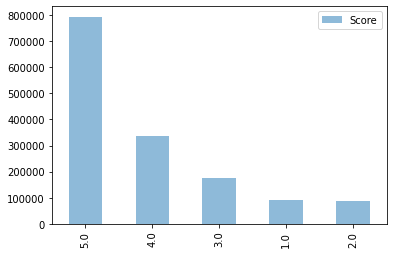


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [28]:
trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

In [29]:
# experiment section, playing with data to see which features to add and how to do them

# idea is to make a user review bias indicator: 
    #for each reviewer who reviews more than once, from a scale from 1-5
    #calculate the average and standard deviation of their reviews
    #if the reviewer only has one review, call their average and standard deviation 0'
    
    #drop biased reviewers => if they have an average rating of <1.1 or 4.9>, they should have bias = 1, else, 0
    
    #ok if not making attributes based on score column, 
    #helpfulness linked to each user, mass reviewers should have a higher helpfulness overall
        #other reviewer patterns
        #are reviews correlated with time?
        
    
    #review length
    #review tf_idf => lsa, as learned in class
    
#     Idea: if tf_idf is too inefficient, take a row with only the first 10-15-20 words of each review, and 
#.          simply do it off of that. ppl start off each review with a "ok, great, Fun, love;"
#           also, ending last 10-15-20 words?
    
    
    
# sentiment analysis

# need to try every type of classifier model to see which accuracy is best






    
# print(reviewer_df)

# Adding Features

In [30]:
def add_num_reviews(df):
    user_counts = df['UserId'].value_counts().reset_index()
    user_counts.columns = ['UserId', 'num_reviews']

    df = pd.merge(df, user_counts, on='UserId', how='left')
    return df

In [31]:
def add_review_length(df):
    df['review_length'] = df.apply(lambda x: len(x))
    df['review_length'] = df['review_length'].fillna(0)
    return df

In [32]:
%%time

nltk.download('stopwords')
stop_words = stopwords.words('english')

def add_tf_idf(df, words = 15):
#     df["Summary"] = df["Summary"].fillna('').astype(str)
    
#     test drop instead of fill
    
#     df['trimmed_text'] = df['Summary'].apply(lambda x: " ".join(x.split()[:words]))
    
    v = TfidfVectorizer(max_features=500, stop_words = stop_words, ngram_range=(1, 2))
    tfidf_matrix = v.fit_transform(df['Summary'].fillna(""))
    
#     scaler = MinMaxScaler(feature_range = (0, 1))
#     tfidf_matrix_scaled = scaler.fit_transform(tfidf_matrix.toarray())
    
#     pca = PCA(n_components=50)
#     tfidf_reduced = pca.fit_transform(tfidf_matrix_scaled)

#     tfidf_pca_df = pd.DataFrame(tfidf_reduced, columns=[f'pca_tfidf_{i}' for i in range(50)])
    
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=v.get_feature_names_out())
    tfidf_df.fillna(0, inplace=True)
    df = pd.concat([df, tfidf_df], axis=1)
    
    return df
    
    
    
    

CPU times: user 109 ms, sys: 116 ms, total: 224 ms
Wall time: 522 ms


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/charlesli/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [33]:
def chunk(df, size = 1/50.0):
    return df.sample(frac = size, random_state = 0)

In [34]:
def add_dates(df):
    df['date_time'] = pd.to_datetime(df['Time'], unit= 's')
    df['date_year'] = df['date_time'].dt.year
    df['day_of_week'] = df['date_time'].dt.weekday
    
    return df

In [35]:
def add_textblob_sentiment(df):
#     here we go !
    df["Text"] = df["Text"].fillna('').astype(str)
    
    df[['polarity', 'sentiment']] = df['Text'].apply(lambda x: TextBlob(x).sentiment).apply(pd.Series)
    
    return df
    

In [36]:
def add_average_review_score(df):
#     def sort_scores(score):
#         if(score > 4.5):
#             return 1
#         elif(score <1.5):
#             return -1
#         else:
#             return 0
        
#     df_no_na = df.dropna(subset=['Score'])

#     df_no_na['user_average_review_score'] = df_no_na.groupby('UserId')['Score'].transform('mean')

#     df_no_na['user_average_review_score'] = df_no_na['user_average_review_score'].apply(sort_scores)

#     df = df.merge(df_no_na[['UserId', 'user_average_review_score']], on='UserId', how='left', suffixes=('', '_y'))

# #     df['user_average_review_score'] = df['user_average_review_score_y']
# #     df.drop(columns=['user_average_review_score_y'], inplace=True)

    df['user_average_review_score'] = df.groupby('UserId')['Score'].transform('mean')
    df['user_average_review_score'].fillna(5, inplace=True)
    
    return df
    

In [37]:
%%time

def add_features_to(df):
    # This is where you can do all your feature extraction

    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)
    
#     filter good reviewers, bad reviewers
#     reviewer patterns
#     sentiment, how much you write, etc. 
#     reviewer id instead of sentiment analysis angle, veracity of the review

#     df = chunk(df, size = 1/50.0)
    df = add_num_reviews(df)
    df = add_review_length(df)
    
    df = add_dates(df)
    df = add_average_review_score(df)
    df = add_textblob_sentiment(df)
    df = add_tf_idf(df)
    
    
    print(df.columns)
    print(df.shape)


    return df

# Load the feature extracted files if they've already been generated
if exists('./data/X_train.csv'):
    X_train = pd.read_csv("./data/X_train.csv")
if exists('./data/X_submission.csv'):
    X_submission = pd.read_csv("./data/X_submission.csv")

else:
    # Process the DataFrame
    train = add_features_to(trainingSet)
    
    # Merge on Id so that the submission set can have feature columns as well
    X_submission = pd.merge(train, testingSet, left_on='Id', right_on='Id')
    X_submission = X_submission.drop(columns=['Score_x'])
    X_submission = X_submission.rename(columns={'Score_y': 'Score'})

    # The training set is where the score is not null
    X_train =  train[train['Score'].notnull()]

    X_submission.to_csv("./data/X_submission.csv", index=False)
    X_train.to_csv("./data/X_train.csv", index=False)


Index(['Id', 'ProductId', 'UserId', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Time', 'Summary', 'Text', 'Score',
       'Helpfulness',
       ...
       'worthy', 'would', 'wow', 'wrong', 'year', 'years', 'yes', 'yet',
       'young', 'zombie'],
      dtype='object', length=518)
(1697533, 518)


/Users/charlesli/opt/anaconda3/lib/python3.8/site-packages/pandas/core/internals/blocks.py:1951: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


CPU times: user 31min 45s, sys: 25min 54s, total: 57min 40s
Wall time: 1h 7min 59s


In [38]:
tf_idf_cols = train.columns.values.tolist()[18:]
print(tf_idf_cols)
# print(len(tf_idf_cols))

# print(train['awesome'].sum())



['10', '3d', '80', 'absolutely', 'acted', 'acting', 'action', 'action movie', 'actors', 'actually', 'adaptation', 'adventure', 'age', 'almost', 'always', 'amazing', 'amazon', 'america', 'american', 'animated', 'animation', 'anime', 'another', 'another great', 'around', 'art', 'average', 'away', 'awesome', 'awesome movie', 'awful', 'baby', 'back', 'bad', 'batman', 'beautiful', 'beginning', 'believe', 'best', 'best movie', 'best movies', 'better', 'better expected', 'beware', 'big', 'bit', 'black', 'blood', 'blu', 'blu ray', 'blue', 'bond', 'book', 'boring', 'bought', 'box', 'boy', 'brilliant', 'british', 'budget', 'buy', 'cast', 'character', 'characters', 'charming', 'children', 'christmas', 'cinema', 'classic', 'classics', 'collection', 'come', 'comedy', 'comes', 'comic', 'coming', 'complete', 'concert', 'cool', 'could', 'could better', 'crazy', 'creepy', 'crime', 'cult', 'cut', 'cute', 'dark', 'day', 'days', 'dead', 'deal', 'death', 'decent', 'definitely', 'delightful', 'die', 'differ

# Sample + Split into training and testing set

In [39]:
# Split training set into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train.drop(columns=['Score']),
    X_train['Score'],
    test_size=1/4.0,
    random_state=0
)

In [40]:
# X_train, X_test, Y_train, Y_test = train_test_split(
#     X_train.drop(columns=['Score']),
#     X_train['Score'],
#     test_size=1/10.0,
#     random_state=0
# )

# print(type(X_train))

# Feature Selection

In [41]:
features = ['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Helpfulness', 'num_reviews', 'review_length', 'date_year', 'day_of_week', 'polarity', 'sentiment', 'user_average_review_score'] + tf_idf_cols
print(features)

# removed time

X_train_select = X_train[features]
X_test_select = X_test[features]
X_submission_select = X_submission[features]


print(X_train_select)

['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Helpfulness', 'num_reviews', 'review_length', 'date_year', 'day_of_week', 'polarity', 'sentiment', 'user_average_review_score', '10', '3d', '80', 'absolutely', 'acted', 'acting', 'action', 'action movie', 'actors', 'actually', 'adaptation', 'adventure', 'age', 'almost', 'always', 'amazing', 'amazon', 'america', 'american', 'animated', 'animation', 'anime', 'another', 'another great', 'around', 'art', 'average', 'away', 'awesome', 'awesome movie', 'awful', 'baby', 'back', 'bad', 'batman', 'beautiful', 'beginning', 'believe', 'best', 'best movie', 'best movies', 'better', 'better expected', 'beware', 'big', 'bit', 'black', 'blood', 'blu', 'blu ray', 'blue', 'bond', 'book', 'boring', 'bought', 'box', 'boy', 'brilliant', 'british', 'budget', 'buy', 'cast', 'character', 'characters', 'charming', 'children', 'christmas', 'cinema', 'classic', 'classics', 'collection', 'come', 'comedy', 'comes', 'comic', 'coming', 'complete', 'concert', 'cool

# Model Creation

In [ ]:
# Learn the model
model = RandomForestClassifier(n_estimators=300, random_state=42, verbose = 2).fit(X_train_select, Y_train)


# model = KNeighborsClassifier(n_neighbors=3).fit(X_train_select, Y_train)

# Predict the score using the model
Y_test_predictions = model.predict(X_test_select)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 300


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.5s remaining:    0.0s


building tree 2 of 300
building tree 3 of 300
building tree 4 of 300
building tree 5 of 300
building tree 6 of 300


# Model Evaluation

Accuracy on testing set =  0.6294891957687916


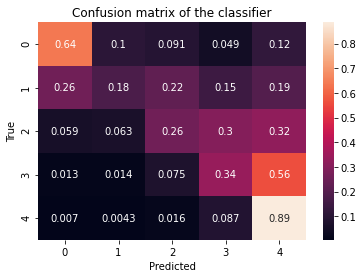

In [43]:
# Evaluate your model on the testing set

print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))

# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Create submission file

In [44]:
# Create the submission file
X_submission['Score'] = model.predict(X_submission_select)
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submission.csv", index=False)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   57.8s finished
